####Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

####Utility Functions

In [5]:
# 1. Function to load and vectorize data
def load_data(train_path='/content/train (1).csv', validation_path='/content/validation.csv', test_path='/content/test (1).csv'):
    train_df = pd.read_csv(train_path)
    validation_df = pd.read_csv(validation_path)
    test_df = pd.read_csv(test_path)

    # Ensure 'message' column is treated as string
    train_df['message'] = train_df['message'].astype(str)
    validation_df['message'] = validation_df['message'].astype(str)
    test_df['message'] = test_df['message'].astype(str)

    return train_df, validation_df, test_df


def vectorize_data(train_df, validation_df, test_df, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()

    # Fit on training data and transform all datasets
    X_train = vectorizer.fit_transform(train_df['message'])
    y_train = train_df['label']

    X_validation = vectorizer.transform(validation_df['message'])
    y_validation = validation_df['label']

    X_test = vectorizer.transform(test_df['message'])
    y_test = test_df['label']

    return X_train, y_train, X_validation, y_validation, X_test, y_test, vectorizer

In [6]:
# 2. Function to fit, score and evaluate model
def fit_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    return model

def score_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    # Return a dictionary instead of a tuple
    return {'y_pred': y_pred, 'accuracy': accuracy, 'auc_roc': roc_auc}

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [7]:
# 3. Function to train and validate model
def train_and_validate_models(X_train, y_train, X_validation, y_validation):
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(probability=True),
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    performances = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        trained_model = fit_model(X_train, y_train, model)
        validation_scores = score_model(trained_model, X_validation, y_validation)
        print(f"Validation Accuracy: {validation_scores['accuracy']:.4f}, AUC-ROC: {validation_scores['auc_roc']:.4f}")

        # Use evaluate_model for validation data
        print(f"Evaluation for {name} on Validation Data:")
        evaluate_model(trained_model, X_validation, y_validation)

        performances[name] = {'model': trained_model, 'metrics': validation_scores}

    return performances

In [8]:
# 4. Function to fine tune hyperparameters
def fine_tune_logistic_regression(X_train, y_train, X_validation, y_validation):
    params = {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    }
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=params, cv=3, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    validation_scores = score_model(best_model, X_validation, y_validation)
    print(f"Fine-Tuned Validation Accuracy: {validation_scores['accuracy']:.4f}, AUC-ROC: {validation_scores['auc_roc']:.4f}")

    return best_model, validation_scores

In [10]:
# 5. Func. to score models on test data
def score_models_on_test(performances, X_test, y_test):
    best_model_name = None
    best_auc_roc = 0
    best_model = None

    for name, info in performances.items():
        print(f"\nScoring {name} on test data...")
        model = info['model']
        test_scores = score_model(model, X_test, y_test)
        print(f"Test Accuracy: {test_scores['accuracy']:.4f}, Test AUC-ROC: {test_scores['auc_roc']:.4f}")

        if test_scores['auc_roc'] > best_auc_roc:
            best_auc_roc = test_scores['auc_roc']
            best_model_name = name
            best_model = model

    print(f"\nBest Model on Test Data: {best_model_name} with AUC-ROC: {best_auc_roc:.4f}")
    return best_model

####Main Script


Training Naive Bayes...
Validation Accuracy: 0.9856, AUC-ROC: 0.9621
Evaluation for Naive Bayes on Validation Data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       722
           1       0.96      0.93      0.95       114

    accuracy                           0.99       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



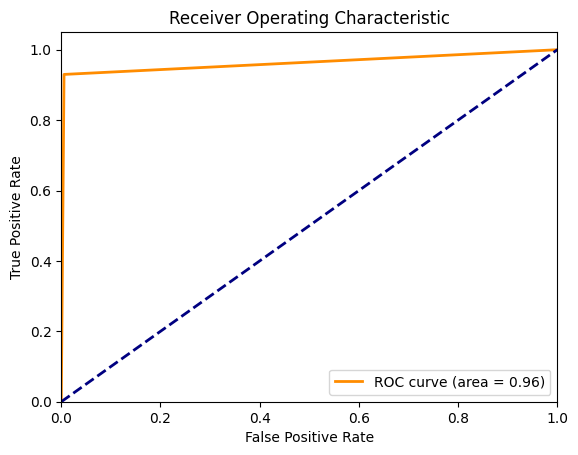


Training Logistic Regression...
Validation Accuracy: 0.9833, AUC-ROC: 0.9423
Evaluation for Logistic Regression on Validation Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       722
           1       0.99      0.89      0.94       114

    accuracy                           0.98       836
   macro avg       0.99      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836



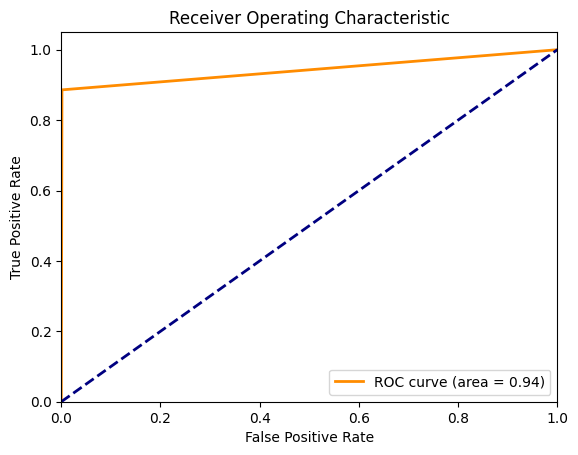


Training SVM...
Validation Accuracy: 0.9856, AUC-ROC: 0.9474
Evaluation for SVM on Validation Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       722
           1       1.00      0.89      0.94       114

    accuracy                           0.99       836
   macro avg       0.99      0.95      0.97       836
weighted avg       0.99      0.99      0.99       836



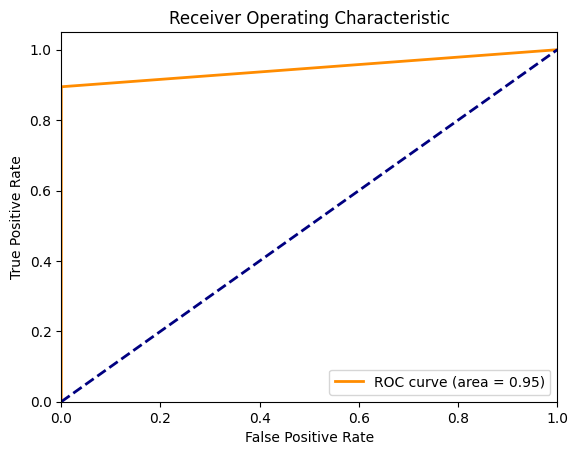


Training Random Forest...
Validation Accuracy: 0.9713, AUC-ROC: 0.8947
Evaluation for Random Forest on Validation Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       722
           1       1.00      0.79      0.88       114

    accuracy                           0.97       836
   macro avg       0.98      0.89      0.93       836
weighted avg       0.97      0.97      0.97       836



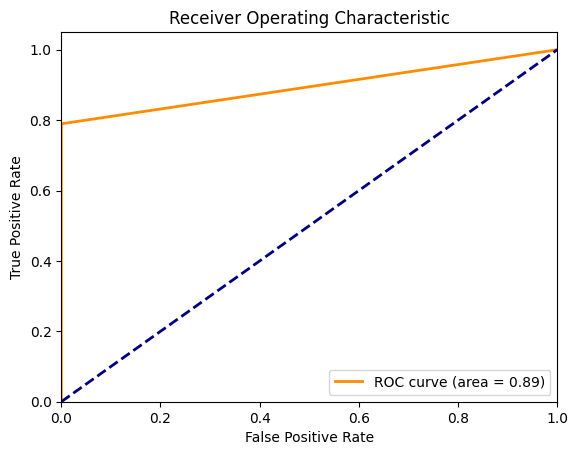


Training Decision Tree...
Validation Accuracy: 0.9617, AUC-ROC: 0.9003
Evaluation for Decision Tree on Validation Data:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       722
           1       0.89      0.82      0.85       114

    accuracy                           0.96       836
   macro avg       0.93      0.90      0.92       836
weighted avg       0.96      0.96      0.96       836



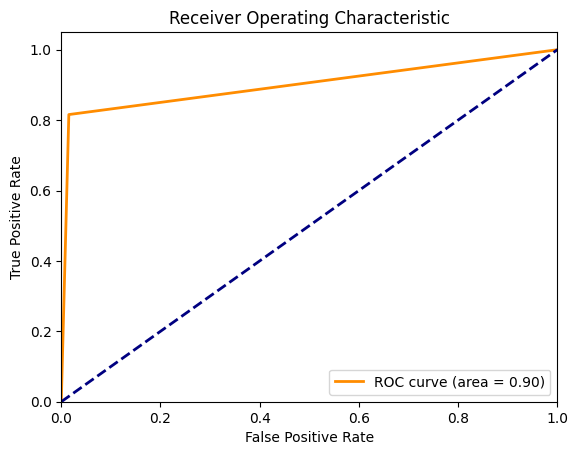

Best Parameters: {'C': 10, 'solver': 'liblinear'}
Fine-Tuned Validation Accuracy: 0.9844, AUC-ROC: 0.9467

Scoring Naive Bayes on test data...
Test Accuracy: 0.9869, Test AUC-ROC: 0.9660

Scoring Logistic Regression on test data...
Test Accuracy: 0.9797, Test AUC-ROC: 0.9317

Scoring SVM on test data...
Test Accuracy: 0.9833, Test AUC-ROC: 0.9413

Scoring Random Forest on test data...
Test Accuracy: 0.9809, Test AUC-ROC: 0.9323

Scoring Decision Tree on test data...
Test Accuracy: 0.9725, Test AUC-ROC: 0.9388

Scoring Fine-Tuned Logistic Regression on test data...
Test Accuracy: 0.9821, Test AUC-ROC: 0.9368

Best Model on Test Data: Naive Bayes with AUC-ROC: 0.9660


In [11]:
if __name__ == "__main__":
    # Load the data
    train_df, validation_df, test_df = load_data()

    # Vectorize the data
    X_train, y_train, X_validation, y_validation, X_test, y_test, vectorizer = vectorize_data(
        train_df, validation_df, test_df)

    # Train and validate models
    performances = train_and_validate_models(X_train, y_train, X_validation, y_validation)

    # Fine-tune Logistic Regression
    fine_tuned_model, fine_tuned_scores = fine_tune_logistic_regression(X_train, y_train, X_validation, y_validation)

    # Add fine-tuned Logistic Regression to performances
    performances['Fine-Tuned Logistic Regression'] = {'model': fine_tuned_model, 'metrics': fine_tuned_scores}

    # Score models on test data and select the best one
    best_model = score_models_on_test(performances, X_test, y_test)